In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=6,threshold=5000,linewidth=200,suppress=True)

In [3]:
col_names = ["id","title","description","brand_id","brand_name","ean","parent_id","chunk_id","brick_id"]
dtypes = {"id":object,"title":object,"description":object,"brand_id":object,"brand_name":object,"ean":object,"parent_id":object,"chunk_id":object,"brick_id":object}

In [4]:
data_orig = pd.read_csv("beauty_leverbaar_20160729.txt",sep="\t",header=None,names=col_names,dtype=dtypes)
data = data_orig

In [5]:
data_full = data[data['brand_id'].notnull()]
data_null = data[data['brand_id'].isnull()]
data_full.reset_index(inplace=True,drop=True)
data_null.reset_index(inplace=True,drop=True)

In [6]:
col_names_y = ['brand_id']
col_names_X = ['title']

In [7]:
from sklearn.cross_validation import StratifiedKFold
kf = StratifiedKFold(data_full['brand_id'],n_folds=5,shuffle=True,random_state=42)

C:\Datascience\Anaconda\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [8]:
train_indices, test_indices = next(iter(kf))

In [9]:
X_train, y_train = data_full[col_names_X].loc[train_indices], data_full[col_names_y].loc[train_indices]
X_test, y_test = data_full[col_names_X].loc[test_indices], data_full[col_names_y].loc[test_indices]

In [10]:
from sklearn.externals import joblib
pipeline = joblib.load('pipeline.pkl')

In [11]:
probas = pipeline.predict_proba(X_test.values.ravel())

In [12]:
predicted_index = np.argsort(probas,axis=1)[:,-1]

In [13]:
predicted_proba = np.sort(probas,axis=1)[:,-1]

In [14]:
predicted_brandid = pipeline.named_steps['sgd'].classes_[predicted_index]

In [15]:
import cPickle as pickle
brand_translator = pickle.load( open( "brand_translator.pkl", "rb" ) )

In [16]:
predicted_brandname = np.array([])

for brand_id in predicted_brandid: 
    predicted_brandname = np.concatenate((predicted_brandname,np.array([brand_translator.get(brand_id,None)])))

In [17]:
predicted_brandname[0:5]

array(['Beurer', 'Slava Zaitsev', 'Vanderbilt', 'adidas', 'Nonchalance'], 
      dtype='|S32')

In [18]:
X_test.head(3)

,title
0,Beurer BS69 Spiegel met Verlichting
4,Slava Zaitsev Maroussia for Women - 50 ml - Ea...
8,Gloria Vanderbilt for Women - 100 ml - Eau de ...


In [19]:
test_set = data_full[['id','title','brand_id','brand_name']].loc[test_indices]

In [20]:
test_set['predicted_proba'] = predicted_proba
test_set['predicted_brandid'] = predicted_brandid
test_set['predicted_brandname'] = predicted_brandname

In [21]:
test_set['correct'] = test_set['brand_id'].isin(test_set['predicted_brandid']) * 1

In [22]:
test_set.iloc[20:23]

,id,title,brand_id,brand_name,predicted_proba,predicted_brandid,predicted_brandname,correct
74,9200000005157420,Oralmedic Mouth Ulcer Treatment,7606679,Oce Bio,0.15850,14865613,Barry M Cosmetics,0
77,9200000005169061,Wetties Verfrissingsdoekjes Pocket Verpakking,7607134,Wetties,0.70011,7607134,Wetties,1
81,9200000005171871,Mentho-10 Mentholpoeder 2% - 75 ml - Huidontsm...,7606557,Mentho 10,0.51779,7606557,Mentho 10,1


([array([   3.,   20.,   19.,   36.,   32.,   61.,   64.,   78.,   87.,  101.,  129.,  158.,  208.,  286.,  340.,  394.,  637.,  849.,  822.,  528.]),
  array([  11.,   46.,   37.,   44.,   44.,   73.,   71.,   89.,   94.,  103.,  134.,  160.,  213.,  286.,  344.,  398.,  637.,  853.,  822.,  529.])],
 array([ 0.023616,  0.072435,  0.121254,  0.170073,  0.218893,  0.267712,  0.316531,  0.36535 ,  0.414169,  0.462989,  0.511808,  0.560627,  0.609446,  0.658266,  0.707085,  0.755904,  0.804723,
         0.853542,  0.902362,  0.951181,  1.      ]),
 <a list of 2 Lists of Patches objects>)

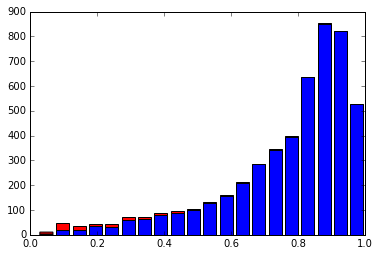

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist([test_set['predicted_proba'][test_set['correct'] == 1],
        test_set['predicted_proba'][test_set['correct'] == 0]],
        stacked=True, color=['b','r'],
        bins=20)

In [24]:
import seaborn as sns

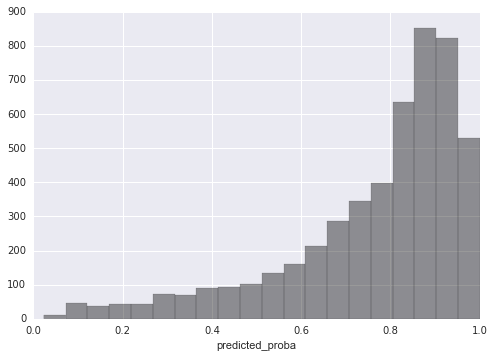

In [25]:
sns.distplot(test_set['predicted_proba'], bins=20, kde=False, hist=True, color="black")

In [26]:
bins = np.linspace(0.05,1.0000000001,20)

In [29]:
bins

array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95,  1.  ])

In [30]:
bin_digits = np.digitize(test_set['predicted_proba'],bins)

In [31]:
test_set['bin_digits'] = bin_digits

In [32]:
test_set.head(3)

,id,title,brand_id,brand_name,predicted_proba,predicted_brandid,predicted_brandname,correct,bin_digits
0,9000000012514720,Beurer BS69 Spiegel met Verlichting,4493486,Beurer,0.49110,4493486,Beurer,1,9
4,9200000005031799,Slava Zaitsev Maroussia for Women - 50 ml - Ea...,7903656,Slava Zaitsev,0.97815,7903656,Slava Zaitsev,1,19
8,9200000005031823,Gloria Vanderbilt for Women - 100 ml - Eau de ...,7452510,Vanderbilt,0.82910,7452510,Vanderbilt,1,16


In [33]:
groupby_correct = test_set.groupby(['correct','bin_digits'])

In [34]:
crosstab = groupby_correct['id'].count().reset_index()

In [35]:
crosstab.head(5)

,correct,bin_digits,id
0,0,0,4
1,0,1,20
2,0,2,22
3,0,3,12
4,0,4,9


In [36]:
crosstab[['correct', 'bin_digits']] = crosstab[['correct', 'bin_digits']].astype(object)

In [37]:
crosstab.dtypes

correct       object
bin_digits    object
id             int64
dtype: object

In [38]:
pd_crosstab = pd.crosstab(test_set['bin_digits'], test_set['correct'])

In [39]:
pd_crosstab.head(3)

correct,0,1
bin_digits,,
0,4,1
1,20,13
2,22,20


In [40]:
pd_crosstab['total'] = pd_crosstab[0] + pd_crosstab[1]

In [41]:
pd_crosstab['perc_correct'] = pd_crosstab[1] / pd_crosstab['total']

In [42]:
pd_crosstab['upper_limit'] = pd_crosstab.index * 0.05 + 0.05
pd_crosstab['lower_limit'] = pd_crosstab.index * 0.05

In [43]:
pd_crosstab = pd_crosstab[['lower_limit','upper_limit',0,1,'total','perc_correct']]

In [44]:
pd_crosstab

correct,lower_limit,upper_limit,0,1,total,perc_correct
bin_digits,,,,,,
0,0.00000,0.05000,4,1,5,0.20000
1,0.05000,0.10000,20,13,33,0.39394
2,0.10000,0.15000,22,20,42,0.47619
3,0.15000,0.20000,12,26,38,0.68421
4,0.20000,0.25000,9,40,49,0.81633
5,0.25000,0.30000,10,48,58,0.82759
6,0.30000,0.35000,13,68,81,0.83951
7,0.35000,0.40000,9,74,83,0.89157
8,0.40000,0.45000,8,86,94,0.91489


In [45]:
pd_crosstab[['lower_limit','perc_correct']]

correct,lower_limit,perc_correct
bin_digits,,
0,0.00000,0.20000
1,0.05000,0.39394
2,0.10000,0.47619
3,0.15000,0.68421
4,0.20000,0.81633
5,0.25000,0.82759
6,0.30000,0.83951
7,0.35000,0.89157
8,0.40000,0.91489


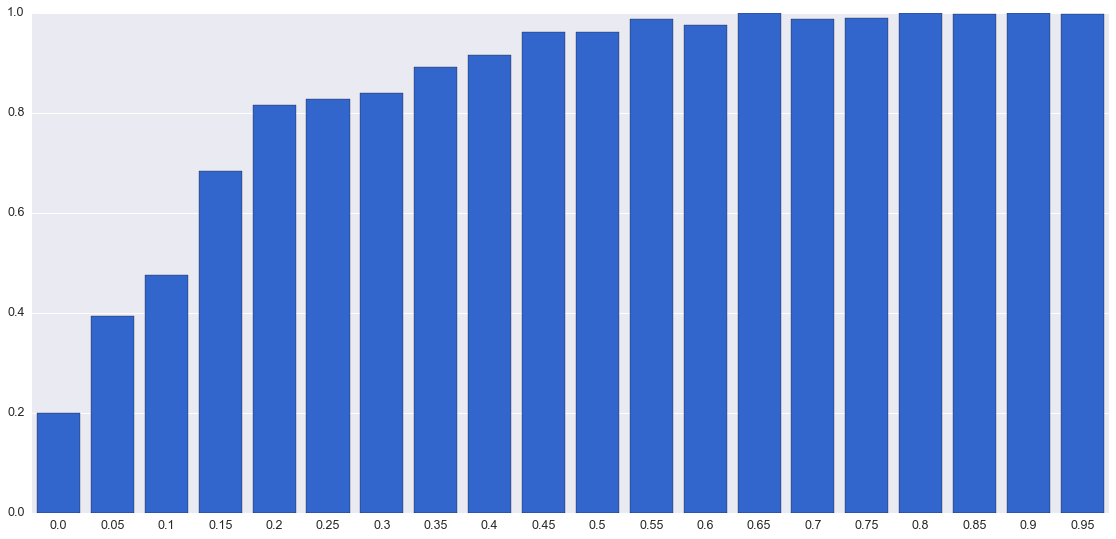

In [46]:
# 0.55 lijkt een goede grens om voorspellingen gewoon door te laten.

sns.set(font_scale=1.25)
ax = sns.factorplot(x='lower_limit', y='perc_correct', kind="bar", data=pd_crosstab, saturation=1.0, size=8, color="#3366cc", aspect=2)
#ax.set(xlabel='% dat model zeker is van merk', ylabel='% merk correct voorspeld door model')
ax.set(xlabel='', ylabel='')
plt.show()

In [47]:
key = pd_crosstab['lower_limit'] >= 0.55
key2 = pd_crosstab['lower_limit'] >= 0.20

key_group = pd_crosstab.groupby([key,key2])

In [48]:
key_group_agg = key_group[[1,'total']].sum()
key_group_agg

correct                     1  total
lower_limit lower_limit             
False       False          60    118
            True          536    594
True        True         4256   4276

In [49]:
key_group_agg['perc_correct'] = key_group_agg[1] / key_group_agg['total'] 
key_group_agg

correct                     1  total  perc_correct
lower_limit lower_limit                           
False       False          60    118       0.50847
            True          536    594       0.90236
True        True         4256   4276       0.99532

In [50]:
from sklearn.metrics import precision_recall_curve as prc

In [51]:
precision, recall, thresholds = prc(y_true=test_set['correct'], probas_pred=test_set['predicted_proba'])

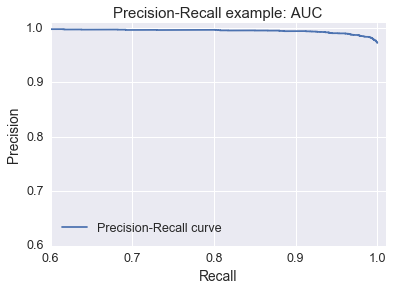

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.6, 1.01])
plt.xlim([0.6, 1.01])
plt.title('Precision-Recall example: AUC')
plt.legend(loc="lower left")
plt.show()

In [53]:
probas_null = pipeline.predict_proba(data_null['title'])

In [54]:
probas_null.shape

(931L, 1019L)

In [55]:
predicted_index_null = np.argsort(probas_null,axis=1)[:,-1]
predicted_proba_null = np.sort(probas_null,axis=1)[:,-1]
predicted_brandid_null = pipeline.named_steps['sgd'].classes_[predicted_index_null]

predicted_brandname_null = np.array([])

for brand_id in predicted_brandid_null: 
    predicted_brandname_null = np.concatenate((predicted_brandname_null,np.array([brand_translator.get(brand_id,None)])))

In [56]:
null_set = data_null[['id','title','brand_id','brand_name']]
null_set['predicted_proba'] = predicted_proba_null
null_set['predicted_brandid'] = predicted_brandid_null
null_set['predicted_brandname'] = predicted_brandname_null

C:\Datascience\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Datascience\Anaconda\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Datascience\Anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [58]:
null_set.sort_values(by='predicted_proba', ascending=False)[(null_set['predicted_proba'] <= 0.55) & (null_set['predicted_proba'] >= 0.0)].head(10)

C:\Datascience\Anaconda\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,id,title,brand_id,brand_name,predicted_proba,predicted_brandid,predicted_brandname
203,9200000054927708,Guerlain Terracotta Joli Teint Powder Duo 10 gr,NaN,NaN,0.54797,7877545,Guerlain
674,9200000054927718,Guerlain Terracotta Joli Teint Powder Duo 10 gr,NaN,NaN,0.54797,7877545,Guerlain
281,9200000056970409,Dkny be delicious london woman edp 50 ml spray,NaN,NaN,0.54469,7819619,DKNY
277,9200000056665684,Loewe - AGUA LOEWE edt vaporizador 50 ml,NaN,NaN,0.54324,1846198,Loewe
626,9200000052201153,Cetaphil milde reiniger 460 ml,NaN,NaN,0.54287,7606046,Cetaphil
794,9200000058282989,Donna Karan DKNY Women Summer 2016 Eau de toil...,NaN,NaN,0.54264,676257,DKNY
123,9200000051601696,OPI Wraped Wild for the Holidays - 2 x 15 ml -...,NaN,NaN,0.54083,12916880,OPI
122,9200000051601692,OPI Wrapped Wild for the Holidays - 2 x 15 ml ...,NaN,NaN,0.54083,12916880,OPI
341,9200000058756533,Diadermine Hydraterende reinigingsdoekjes - 1 ...,NaN,NaN,0.54038,7452199,Diadermine
792,9200000058263593,Black Musk Eau De Parfum 50 ml,NaN,NaN,0.54027,7584574,Alyssa Ashley


In [59]:
key = null_set['predicted_proba'] >= 0.55
null_set['id'].groupby(key).count()

predicted_proba
False    495
True     436
dtype: int64

In [60]:
436 / (436 + 495.0)

0.4683136412459721

In [61]:
len(data_null) * 1.0 / len(data)

0.037302668483051526

In [62]:
bin_digits_null = np.digitize(null_set['predicted_proba'], bins)

In [63]:
null_set['bins'] = bin_digits_null

C:\Datascience\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [64]:
null_set['lower_limit'] = null_set['bins'] * 0.05

In [65]:
null_set.head(3)

,id,title,brand_id,brand_name,predicted_proba,predicted_brandid,predicted_brandname,bins,lower_limit
0,1004004012991345,Create The Look Lipgloss Set,NaN,NaN,0.12296,9647926,Disney Minnie,2,0.10000
1,9200000008610843,Hugo Boss Botteld Night After Shave Balm,NaN,NaN,0.64952,7819590,Hugo Boss,12,0.60000
2,9200000011681157,LANCASTER SUMMER SPLASH EDT 100ML NEW,NaN,NaN,0.45926,1062882,Lancaster,9,0.45000


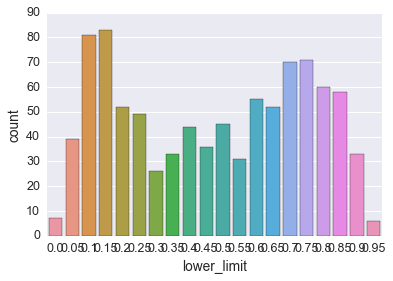

In [68]:
sns.countplot(x='lower_limit', data=null_set)

In [69]:
null_set.groupby('lower_limit').count()['id'].reset_index()

,lower_limit,id
0,0.00000,7
1,0.05000,39
2,0.10000,81
3,0.15000,83
4,0.20000,52
5,0.25000,49
6,0.30000,26
7,0.35000,33
8,0.40000,44
9,0.45000,36


In [77]:
null_set.sort_values(by='lower_limit', ascending=False).iloc[50:55]

,id,title,brand_id,brand_name,predicted_proba,predicted_brandid,predicted_brandname,bins,lower_limit
145,9200000051917119,Loreal - Glam Shine 6H - Lipgloss - 200 6H Mauve,NaN,NaN,0.86233,12925562,L’Oréal Paris,17,0.85000
365,9200000058937657,Yves Saint Laurent L'Homme Libre - Cologne Ton...,NaN,NaN,0.85168,941800,Yves Saint Laurent,17,0.85000
156,9200000052198283,Annemarie Borlind Poederrouge Rose Del21,NaN,NaN,0.85503,7584652,Annemarie Börlind,17,0.85000
206,9200000055359131,Acqua Di Parma - ACQUA DI PARMA deo vaporizado...,NaN,NaN,0.85316,12960856,Acqua Di Parma,17,0.85000
210,9200000055359153,Acqua Di Parma - MAGNOLIA NOBILE deo vaporizad...,NaN,NaN,0.86727,12960856,Acqua Di Parma,17,0.85000


In [267]:
null_set.to_csv("20161021_BeautyProducten_zonderMerk_Predictions.csv")